In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('kaggle-spam2.csv')

In [3]:
df.head(1)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
messagesdf = pd.DataFrame({'message': df.v2.values, 'label': df.v1.values})

In [5]:
messagesdf.head(5)

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [6]:
messagesdf.describe()

,message,label
count,5571,5572
unique,5163,2
top,"Sorry, I'll call later",ham
freq,30,4825


In [7]:
messagesdf['label'].describe()

count     5572
unique       2
top        ham
freq      4825
Name: label, dtype: object

In [8]:
msgs = []
labels = []
ulabels = []

def import_data():
    global msgs, labels, ulabels
    msgs = messagesdf['message']
    labels = messagesdf['label']
    ulabels = sorted(list(set(labels)))

%time import_data()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 506 µs


In [9]:
from collections import Counter

def count_data(labels, categories):
    c = Counter(categories)
    cont = dict(c)
    tot = sum(list(cont.values()))
    d = {
        "category": labels,
        "msgs": [cont[l] for l in labels],
        "percent": [cont[l]/tot for l in labels]
    }
    print(pd.DataFrame(d))
    print("total\t",tot)
    return cont

cont = count_data(ulabels, labels)

  category  msgs   percent
0      ham  4825  0.865937
1     spam   747  0.134063
total	 5572


In [10]:
%matplotlib inline

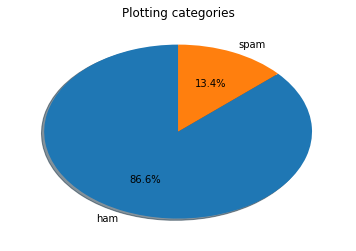

In [11]:
import pylab as pl

def categories_pie_plot(cont, tit):
    global ulabels
    sizes = [cont[l] for l in ulabels]
    pl.pie(sizes, explode=(0,0), labels = ulabels, autopct='%1.1f%%', shadow=True, startangle=90)
    pl.title(tit)
    pl.show()
    
categories_pie_plot(cont, "Plotting categories")

In [13]:
from sklearn.utils import shuffle

X_train = []
y_train = []
X_test = []
y_test = []

def split_data():
    global msgs, labels
    global X_train, X_test, y_train, y_test, ulabels
    N = len(msgs)
    Ntrain = int(N * 0.7)
    msgs, labels = shuffle(msgs, labels, random_state=0)
    X_train = msgs[:Ntrain]
    y_train = labels[:Ntrain]
    X_test = msgs[Ntrain:]
    y_test = labels[Ntrain:]

In [14]:
%time split_data()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 31.8 ms


In [15]:
cont2 = count_data(ulabels, y_train)

  category  msgs  percent
0      ham  3368  0.86359
1     spam   532  0.13641
total	 3900


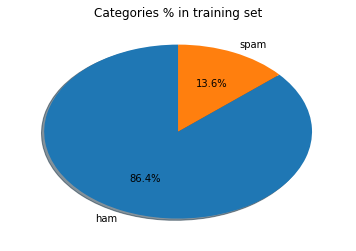

In [16]:
categories_pie_plot(cont2, "Categories % in training set")

In [17]:
cont3 = count_data(ulabels, y_test)

  category  msgs   percent
0      ham  1457  0.871411
1     spam   215  0.128589
total	 1672


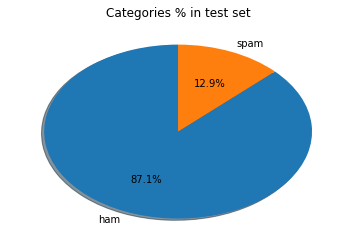

In [18]:
categories_pie_plot(cont3, "Categories % in test set")

## Train the classifier

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
import numpy as np
import pprint

nlabels = len(ulabels)

nrows = nlabels
ncols = nlabels

X_train = X_train.astype('U')
X_test = X_test.astype('U')

text_clf = None 

def train_test():
    global X_train, y_train, X_test, y_test
    global text_clf
    text_clf = Pipeline([
        ('vect', CountVectorizer()), 
        ('tfidf', TfidfTransformer()), 
        ('clf', MultinomialNB())
    ])
    
    text_clf = text_clf.fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    return predicted

In [28]:
X_train[:20]

4456    Aight should I just plan to come up later toni...
690                                    Was the farm open?
944     I sent my scores to sophas and i had to do sec...
3768    Was gr8 to see that message. So when r u leavi...
1189    In that case I guess I'll see you at campus lodge
4437    Nothing will ever be easy. But don't be lookin...
3587    If you were/are free i can give. Otherwise nal...
1982    Hey i will be late... i'm at amk. Need to drin...
2038          Hey are we going for the lo lesson or gym? 
2078                       85233 FREE>Ringtone!Reply REAL
4224    \The world suffers a lot... Not because of the...
2425    Hey!!! I almost forgot ... Happy B-day babe ! ...
3975                  I wish u were here. I feel so alone
2690    sports fans - get the latest sports news str* ...
1999        LMAO where's your fish memory when I need it?
3348                               Oh is it! Which brand?
134     Want 2 get laid tonight? Want real Dogging loc...
3849    I to a

In [29]:
type(X_train[1])

str

In [30]:
y_train[1]

'ham'

In [31]:
%time predicted = train_test()

CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 150 ms


In [19]:
metrics.accuracy_score(y_test, predicted)

0.9605263157894737

In [32]:
print(metrics.classification_report(y_test, predicted, target_names=ulabels))

             precision    recall  f1-score   support

        ham       0.96      1.00      0.98      1457
       spam       1.00      0.69      0.82       215

avg / total       0.96      0.96      0.96      1672



In [33]:
mat = metrics.confusion_matrix(y_test, predicted, labels=ulabels)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
cm

array([[1.        , 0.        ],
       [0.30697674, 0.69302326]])

In [34]:
mat = metrics.confusion_matrix(y_test, predicted, labels=ulabels)
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
cm

array([[1.        , 0.        ],
       [0.30697674, 0.69302326]])

In [35]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title= 'Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:5.2f}'.format(cm[i, j]), horizontalalignment='center', color='white' if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.show()
        

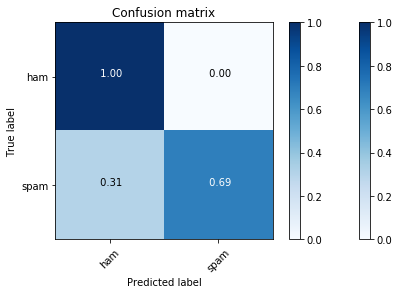

In [36]:
plot_confusion_matrix(cm, ulabels, title='Confusion matrix')

In [37]:
def resume_data(labels,y_train, f1s):
    c = Counter(y_train)
    cont = dict(c)
    tot = sum(list(cont.values()))
    nlabels = len(labels)
    d = {
        "category": [labels[i] for i in range(nlabels)],
        "percent": [cont[labels[i]] / tot for i in range(nlabels)],
        "f1-score": [f1s[i] for i in range(nlabels)],
    }
    
    print(pd.DataFrame(d))
    print("total \t", tot)
    return cont

In [38]:
f1s = metrics.f1_score(y_test, predicted, labels = ulabels, average=None)
cont3 = resume_data(ulabels, y_train, f1s)

  category  percent  f1-score
0      ham  0.86359  0.977852
1     spam  0.13641  0.818681
total 	 3900


In [39]:
text_clf

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [48]:
import pickle

f = open('text-classifier.obj','wb')
# Save model pipeline to file
pickle.dump(text_clf, f)
# f.write(s)

In [50]:
!ls -s text-classifier.obj

652 text-classifier.obj


### Load up model from disk and classify some items to test

In [55]:
f2 = open('text-classifier.obj','rb')
model1 = pickle.load(f2)

In [59]:
model1.predict(['free entry wkly comp'])

array(['spam'], dtype='<U4')

In [58]:
model1.predict(['i saw a dinosaur yesterday.'])

array(['ham'], dtype='<U4')

## Save and load model using scikitlearn's joblib

In [61]:
from sklearn.externals import joblib

with open('text-classifier-2.obj','wb') as file_handle:
    joblib.dump(text_clf, file_handle)

Read saved model and classify sample text

In [67]:
saved_model = None
with open('text-classifier-2.obj','rb') as file_handle:
    global saved_model
    saved_model = joblib.load(file_handle)
r1 = saved_model.predict(['free wkly comp'])
r2 = saved_model.predict(['where is the jetpack'])

print(r1,r2)

['spam'] ['ham']
